In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 26a

##  Convolutional Neural Network (CNN) DenseNet
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

<img src='images/dense_net.png' style = 'width:1200px;' alt="densenet" align="left"/>

In [2]:
### Import Libraries

import tensorflow as tf

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf

    
%matplotlib inline

In [3]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models'
valDir = 'flowers_validation'
altName = 'densenet_flowers'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

EPOCHS = 100 # number of cycles to run

BATCH_SIZE = 32

ALPHA = 0.1


TEST_SIZE = 0.2

IMG_HEIGHT = 200

IMG_WIDTH = 200

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 
FILL_MODE = 'nearest'

ES_PATIENCE = 10 # if performance does not improve stop

LR_PATIENCE = 5 # if performace is not improving reduce alpha

LR_FACTOR = 0.8 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,4),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [4]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [5]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.subplot(1,2,1)

    train_labels = np.concatenate([y for x, y in tr_ds], axis=0).squeeze()
    
    unique, counts = np.unique(train_labels, return_counts=True)
    
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.8)
    
    plt.title('Training Set')
    
    plt.xticks(range(len(unique)), class_names);


    plt.subplot(1,2,2)

    val_labels = np.concatenate([y for x, y in ts_ds], axis=0).squeeze()
    
    unique, counts = np.unique(val_labels, return_counts=True)
    
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.8)
    
    plt.title('Validation Set')
    
    plt.xticks(range(len(unique)), class_names);

In [6]:
from tensorflow.keras.applications import DenseNet169

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [7]:
data_dir = os.path.join(inpDir, subDir)

In [8]:
data_dir

'../input/flower_photos'

In [9]:
### For Colab Users only.

In [10]:
_ = '''import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''

In [11]:
# load data and split in training and validation from a sub dir

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="training",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


2022-12-17 15:51:39.589903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 15:51:39.610530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 15:51:39.610783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 15:51:39.611467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
#!ls '../input/valid_flowers'

### Is it picking the class names?

In [13]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot a batch from the training set and display the class name below each image.


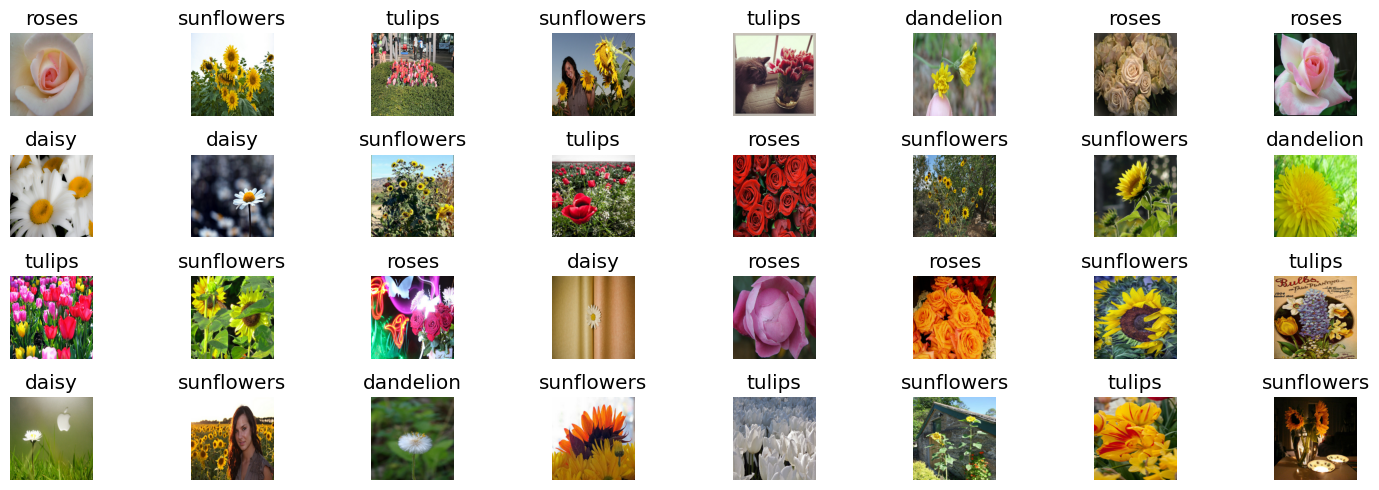

In [14]:
plt.figure(figsize=(15,5))

for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8), 8, i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i]])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

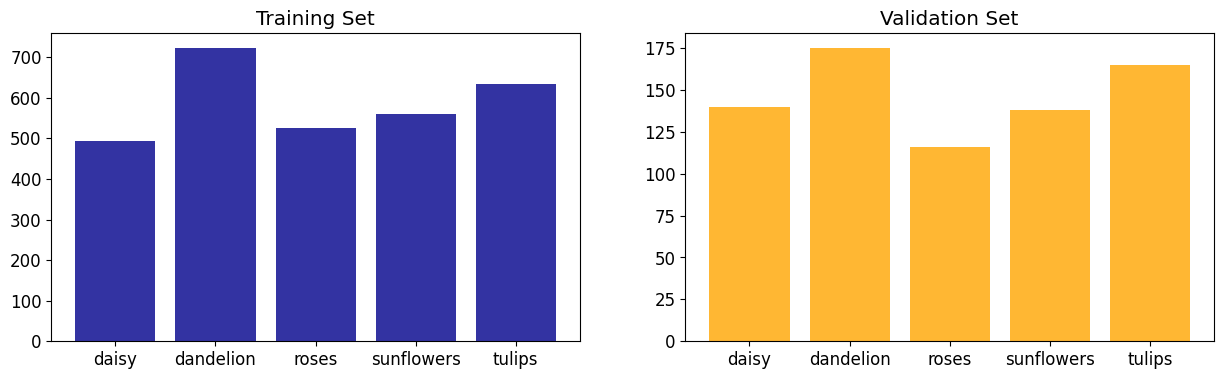

In [15]:
fn_plot_label(train_ds, test_ds)

### Input shape

If we plan to use input layer, we need input shape. Alternatively, we use `.build()` on the model and let framework capture input shape from the data

In [16]:
images[i].shape

TensorShape([200, 200, 3])

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255.)

img_batch, l_batch = next(iter(train_ds))

img = img_batch[0]

print (np.max(img), np.min(img))

train_ds = train_ds.map(lambda X, y: (normalization_layer(X), y) )
test_ds = test_ds.map(lambda X, y: (normalization_layer(X), y) )

img_batch, l_batch = next(iter(train_ds))

img = img_batch[0]
print (np.max(img), np.min(img))

255.0 0.0
1.0 0.0


In [18]:
## Optimize for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [19]:
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [20]:
for layer in densenet_model.layers:
    layer.trainable = False

In [21]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 50, 50, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 50, 50, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 50, 50, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 25, 25, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 25, 25, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 25, 25, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 25, 25, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 25, 25, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 25, 25, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 25, 25, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 25, 25, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 12, 12, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 12, 12, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 12, 12, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 12, 12, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 12, 12, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 12, 12, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 12, 12, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 12, 12, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 12, 12, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 12, 12, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 12, 12, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 12, 12, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 12, 12, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 12, 12, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 12, 12, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 12, 12, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 12, 12, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 12, 12, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 12, 12, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 12, 12, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 12, 12, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 pool4_pool (AveragePooling2D)  (None, 6, 6, 640)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 6, 6, 640)   2560        ['pool4_pool[0][0]']             
 ization)                                                                                         
                                                                                                  
 conv5_block1_0_relu (Activatio  (None, 6, 6, 640)   0           ['conv5_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 6, 6, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 6, 6, 128)    98304       ['conv5_block5_0_relu[0][0]']    
                                                                                                  
 conv5_block5_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv5_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_1_relu (Activatio  (None, 6, 6, 128)   0           ['conv5_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv5_block5_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv5_block9_1_relu[0][0]']    
                                                                                                  
 conv5_block9_concat (Concatena  (None, 6, 6, 928)   0           ['conv5_block8_concat[0][0]',    
 te)                                                              'conv5_block9_2_conv[0][0]']    
                                                                                                  
 conv5_block10_0_bn (BatchNorma  (None, 6, 6, 928)   3712        ['conv5_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block14_0_bn (BatchNorma  (None, 6, 6, 1056)  4224        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_0_relu (Activati  (None, 6, 6, 1056)  0           ['conv5_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_1_conv (Conv2D)  (None, 6, 6, 128)    135168      ['conv5_block14_0_relu[0][0]']   
                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block18_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv5_block18_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block18_1_relu (Activati  (None, 6, 6, 128)   0           ['conv5_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block18_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv5_block18_1_relu[0][0]']   
                                                                                                  
 conv5_block18_concat (Concaten  (None, 6, 6, 1216)  0           ['conv5_block17_concat[0][0]',   
 ate)     

 conv5_block22_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv5_block22_1_relu[0][0]']   
                                                                                                  
 conv5_block22_concat (Concaten  (None, 6, 6, 1344)  0           ['conv5_block21_concat[0][0]',   
 ate)                                                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 6, 6, 1344)  5376        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 6, 6, 1344)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block27_0_relu (Activati  (None, 6, 6, 1472)  0           ['conv5_block27_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, 6, 6, 128)    188416      ['conv5_block27_0_relu[0][0]']   
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv5_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block27_1_relu (Activati  (None, 6, 6, 128)   0           ['conv5_block27_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block31_1_relu (Activati  (None, 6, 6, 128)   0           ['conv5_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block31_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv5_block31_1_relu[0][0]']   
                                                                                                  
 conv5_block31_concat (Concaten  (None, 6, 6, 1632)  0           ['conv5_block30_concat[0][0]',   
 ate)                                                             'conv5_block31_2_conv[0][0]']   
                                                                                                  
 conv5_blo

In [22]:
num_classes = len(class_names)

In [23]:
# Create Model objecct
def build_model(d_model, n_classes):

    krnl_init = tf.keras.initializers.GlorotUniform(
                                       seed=RANDOM_STATE )


    model = tf.keras.Sequential()
    
    # Scaling all images between 0 and 1
    #model.add(tf.keras.layers.Rescaling(1./255))

    # Data Augumentation
    model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed=RANDOM_STATE ))
    model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode = FILL_MODE, seed=RANDOM_STATE ))

    
    model.add(densenet_model)  # 6x6 X 1664

    
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2D(1664, (3, 3),
                                     kernel_initializer = krnl_init,
                                     activation='relu'))   # 4x4
    # model.add(layers.BatchNormalization())

    #model.add(tf.keras.layers.Conv2D(5, (4, 4)))            # using 4x4 kernel to see the complete image

    model.add(tf.keras.layers.Flatten())

    # First Dense set
    model.add(tf.keras.layers.Dense(1024,
                                    kernel_initializer = krnl_init, 
                                    activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.1))
    
    
    # output layer
    model.add(tf.keras.layers.Dense(n_classes,
                                  kernel_initializer = krnl_init
                                  ))

    #Using softmax activation function at the last layer which is used for multi class classification
    #model.add(tf.keras.layers.Activation('softmax'))

    return model

In [24]:
model = build_model(densenet_model,num_classes) 

In [25]:
# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Reduction schedukle for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)


checkpoint_prefix = os.path.join(checkpoint_dir, altName)

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [26]:
#alpha = ALPHA
alpha = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    callbacks=[ early_callback, model_callback, lr_reduce],
                    epochs=EPOCHS)

Epoch 1/100


2022-12-17 15:51:50.354983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-12-17 15:51:50.752927: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 15:51:52.556522: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


92/92 [==============================] - ETA: 0s - loss: 3.2881 - accuracy: 0.6996
Epoch 1: val_loss improved from inf to 0.43825, saving model to ../models/flower_photos/densenet_flowers
92/92 [==============================] - 26s 197ms/step - loss: 3.2881 - accuracy: 0.6996 - val_loss: 0.4383 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8569
Epoch 2: val_loss improved from 0.43825 to 0.38208, saving model to ../models/flower_photos/densenet_flowers
92/92 [==============================] - 13s 137ms/step - loss: 0.4217 - accuracy: 0.8569 - val_loss: 0.3821 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8730
Epoch 3: val_loss did not improve from 0.38208
92/92 [==============================] - 11s 124ms/step - loss: 0.3549 - accuracy: 0.8730 - val_loss: 0.4268 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 4/100
92/92 [============

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 6, 6, 1664)        0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 1664)        24921728  
                                                                 
 flatten (Flatten)           (None, 26624)             0         
                                                        

In [41]:
#tf.keras.utils.plot_model(model, "flowers_model.png")

In [28]:
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy,lr
0,3.288143,0.699591,0.438251,0.833787,0.0010
1,0.421651,0.856948,0.382084,0.865123,0.0010
2,0.354926,0.872956,0.426817,0.862398,0.0010
3,0.323467,0.888624,0.403894,0.873297,0.0010
4,0.308757,0.892030,0.366930,0.891008,0.0010
5,0.288100,0.896117,0.367662,0.893733,0.0010
6,0.260114,0.911104,0.341145,0.895095,0.0010
7,0.226541,0.921662,0.367654,0.895095,0.0010
8,0.253364,0.905313,0.428749,0.869210,0.0010
9,0.263056,0.910082,0.401419,0.892371,0.0010


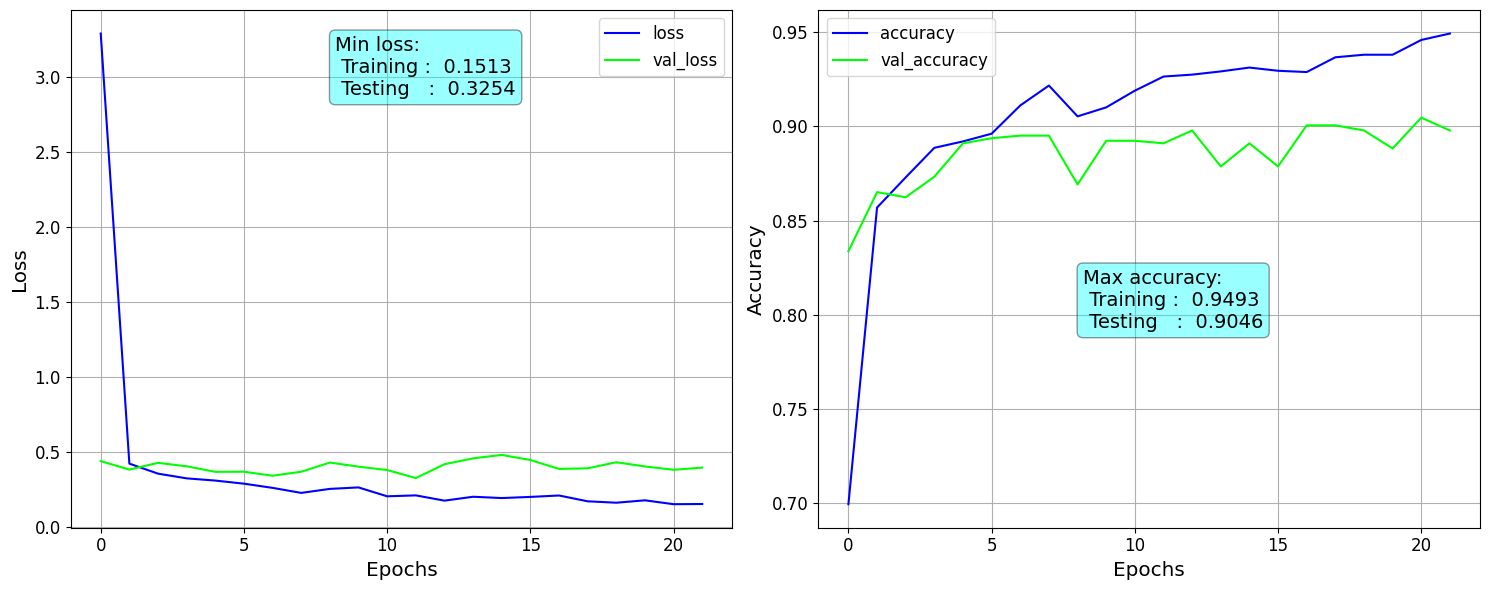

In [29]:
fn_plot_hist(res_df)

### Evaluate the model

In [30]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

23/23 [==============================] - 2s 78ms/step - loss: 0.3254 - accuracy: 0.8910


In [31]:
yhat = model.predict(test_ds)

23/23 [==============================] - 3s 77ms/step


In [32]:
y_test = np.concatenate([y for X, y in test_ds], axis=0).squeeze()

In [33]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score on Test Data : 0.8910


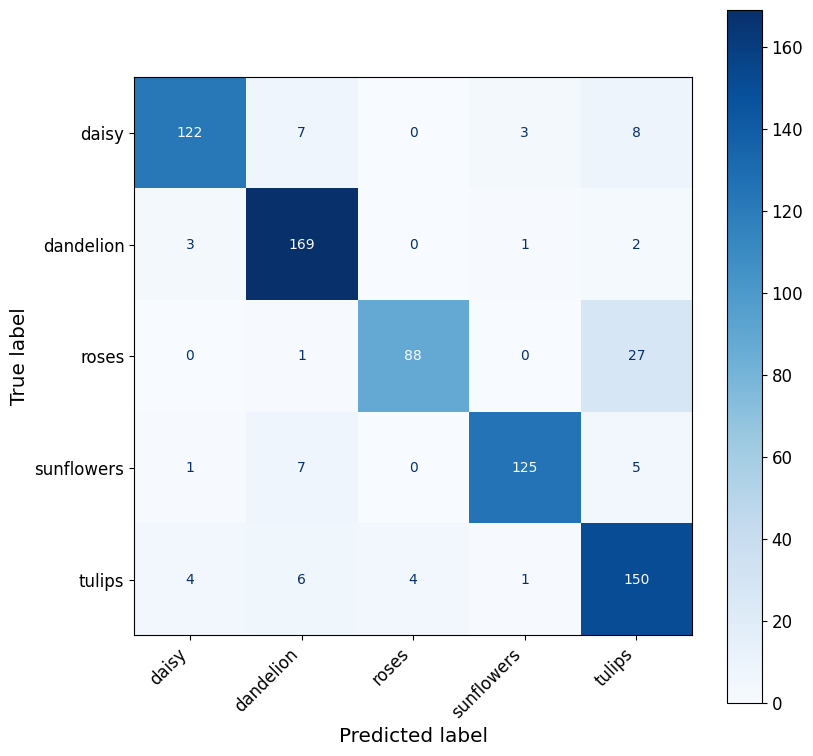

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))
disp.plot(ax = ax, cmap=plt.cm.Blues);
ax.set_xticklabels(class_names,rotation=45, ha='right');

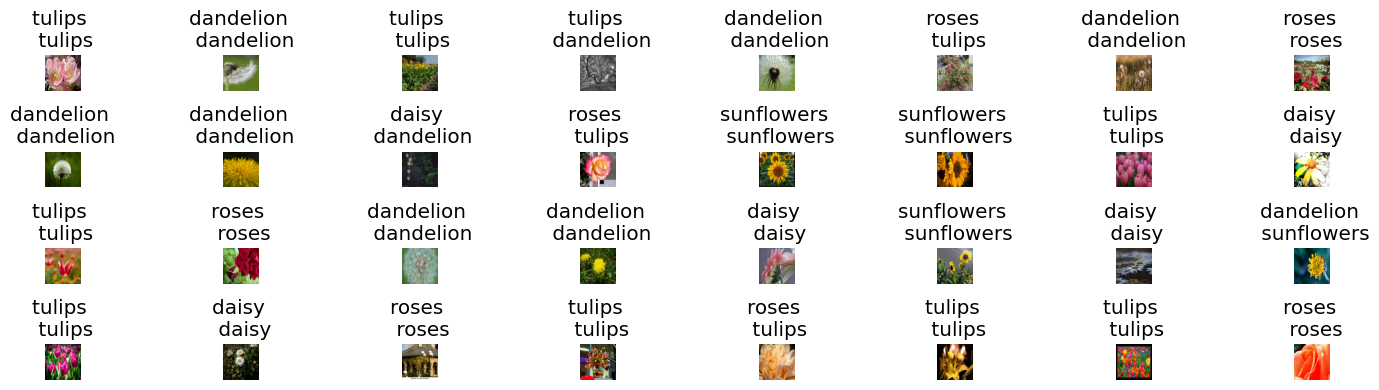

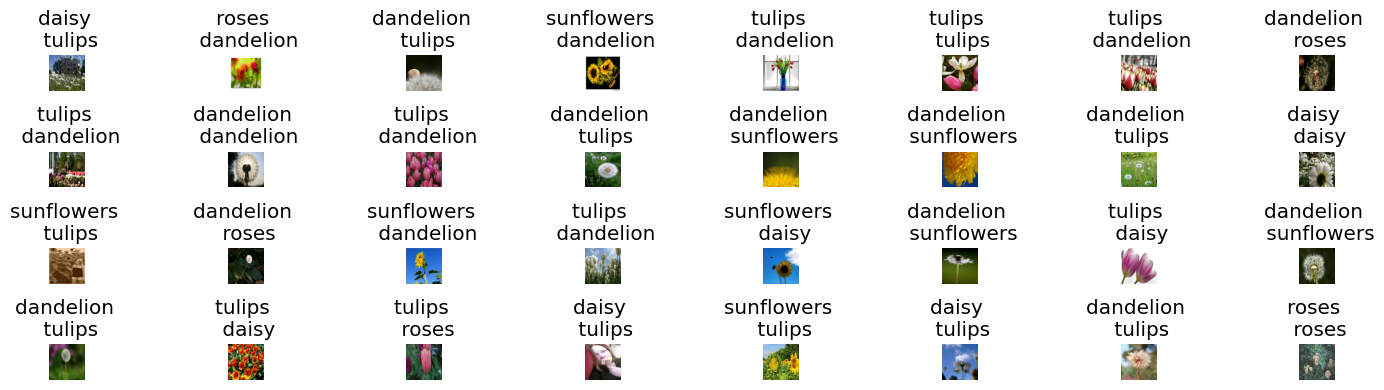

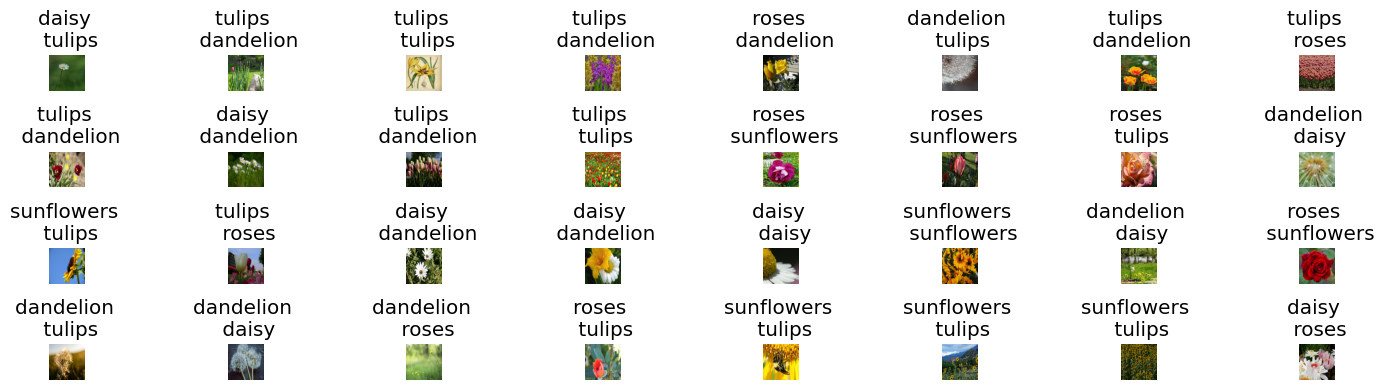

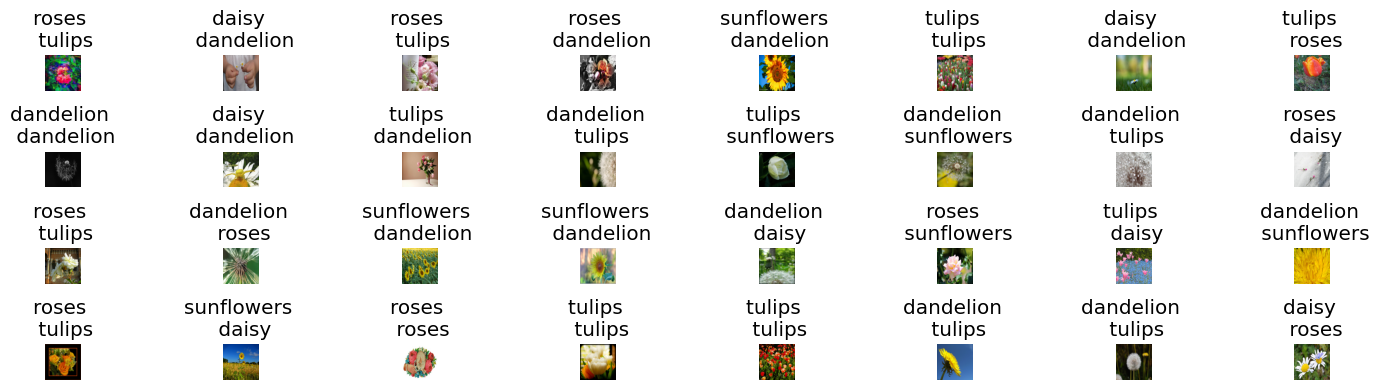

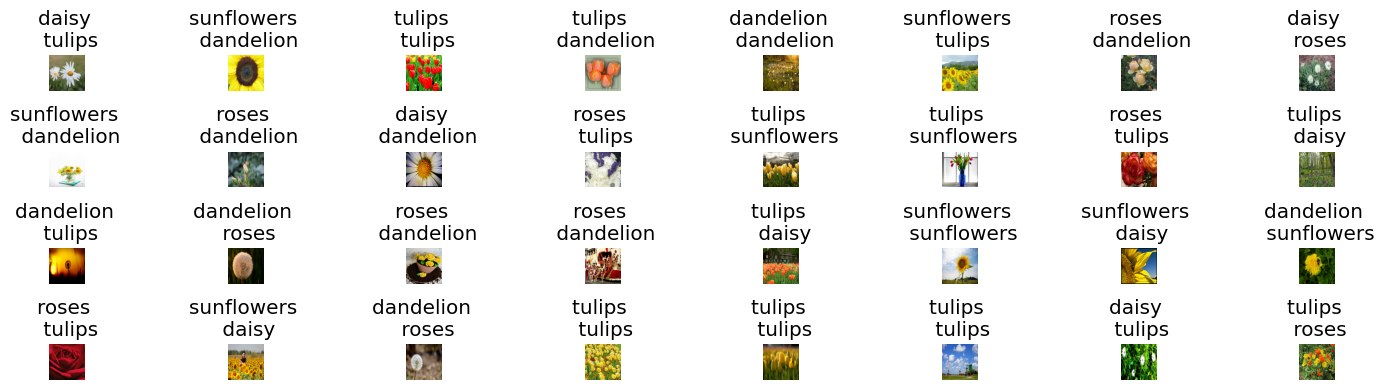

In [35]:
for images, labels in test_ds.take( 5 ):
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy())
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()

In [36]:
model_path = checkpoint_prefix+'.h5'
model.save(model_path, save_format='h5')

new_model = tf.keras.models.load_model(model_path)

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 6, 6, 1664)        0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 1664)        24921728  
                                                                 
 flatten (Flatten)           (None, 26624)             0         
                                                        

In [37]:
yhat = new_model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format( accuracy_score(y_test, y_pred)))

23/23 [==============================] - 3s 76ms/step
Accuracy score on Test Data : 0.8910


## Running on Validation Dataset

In [38]:
val_dir = os.path.join(inpDir, valDir)



val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, 
                                                     validation_split=None, 
                                                     seed=RANDOM_STATE,
                                                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE)

NotFoundError: Could not find directory ../input/flowers_validation

In [ ]:
plt.figure(figsize=(15,5))

for images, labels in val_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8), 8, i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i]])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
val_ds = val_ds.map(lambda X, y: (normalization_layer(X), y) )

In [ ]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
test_loss, test_acc = new_model.evaluate(val_ds, verbose=1)

In [ ]:
yhat = new_model.predict(val_ds)

y_pred = yhat.argmax(axis = 1)

y_test = np.concatenate([y for x, y in val_ds], axis=0).squeeze()

print('Accuracy score on Test Data :{:.4f}'.format(accuracy_score(y_test, y_pred)) )

In [ ]:
for images, labels in val_ds.take( 5 ):
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy())
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()